In [82]:
import os
from pathlib import Path
import re


import numpy as np
import scipy as sp

from matplotlib import pyplot as plt
from sklearn.manifold import MDS
from sklearn import manifold
from sklearn.decomposition import PCA

import ot
import shutil
from tqdm import tqdm
## IMPORT USER DEFINED LIBRARIES ##################################################################
import utils


# Simplex creation notebook

In this notebook we just create random ponitclouds to use as templates that will be separated enough so that the distance to a target plotted in the simplex looks good.

# Utils

In [84]:
import secrets

def simplex_grid(N=20):
    """Generate points on a 2D simplex grid (triangle) with N divisions per edge."""    
    N = N
    pts = []
    for l in range(N + 1):
        for j in range(N + 1 - l):
            k = N - l - j
            pts.append((l / N, j / N, k / N))
    pts=np.array(pts)
    return pts

def random_rbf_deformation(pts,
                           num_ctrl=20,
                           sigma=0.3,
                           max_disp=0.3,
                           seed=None):
    """
    pts: (N, 2) array in some domain, e.g. [0,1]^2
    num_ctrl: number of random control points
    sigma: RBF width (in units of the domain)
    max_disp: max magnitude of control displacements (same units as coords)
    """
    if seed is None:
        seed = secrets.randbits(256)
    rng = np.random.default_rng(seed)

    # 1) Random control points within bounding box of pts
    mins = pts.min(axis=0)
    maxs = pts.max(axis=0)
    ctrl_pts = rng.uniform(mins, maxs, size=(num_ctrl, 2))

    # 2) Random displacements assigned to control points
    ctrl_disp = rng.uniform(-max_disp, max_disp, size=(num_ctrl, 2))

    # 3) Compute RBF weights for each data point
    #    shape: (N, num_ctrl)
    diff = pts[:, None, :] - ctrl_pts[None, :, :]      # (N, K, 2)
    sqdist = np.sum(diff**2, axis=-1)                  # (N, K)
    weights = np.exp(-sqdist / (2.0 * sigma**2))       # (N, K)

    # Normalize weights so they don't blow up
    weights_sum = np.sum(weights, axis=1, keepdims=True) + 1e-12
    weights = weights / weights_sum

    # 4) Interpolated displacement field at pts
    disp = weights @ ctrl_disp                          # (N, 2)

    # 5) Deformed points
    pts_deformed = pts + disp
    return pts_deformed, disp, ctrl_pts, ctrl_disp, seed


def plot_point_cloud(pts, title='Point Cloud'):
    """Plot 2D point cloud. pts is (N, 2) array."""
    plt.figure(figsize=(4,4))
    plt.scatter(pts[:,0], pts[:,1], s=10, c='k')
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid()
    plt.show() 

def compute_distance_matrix(pts):
    """Compute pairwise Euclidean distance matrix for pts."""
    diff = pts[:, None, :] - pts[None, :, :]  # (N, N, 2)
    dist_matrix = np.sqrt(np.sum(diff**2, axis=-1))  # (N, N)
    return dist_matrix  

def create_next_run_folder(base_dir, prefix="run_"):
    """
    Creates the next run folder (e.g., run_01, run_02, ...) inside base_dir.
    Returns the full path of the new folder.
    """
    os.makedirs(base_dir, exist_ok=True)

    pattern = re.compile(rf"{prefix}(\d+)$")
    max_n = 0

    for name in os.listdir(base_dir):
        match = pattern.match(name)
        if match:
            max_n = max(max_n, int(match.group(1)))

    next_n = max_n + 1
    new_folder = os.path.join(base_dir, f"{prefix}{next_n:02d}")
    os.makedirs(new_folder, exist_ok=True)

    return new_folder

def find_last_run_folder(base_dir, prefix="run_"):
    """
    Finds the last run folder (e.g., run_01, run_02, ...) inside base_dir.
    Returns the full path of the last folder.
    """
    pattern = re.compile(rf"{prefix}(\d+)$")
    max_n = -1
    last_folder = None

    for name in os.listdir(base_dir):
        match = pattern.match(name)
        if match:
            n = int(match.group(1))
            if n > max_n:
                max_n = n
                last_folder = os.path.join(base_dir, name)

    return last_folder


# Generate

Number of points in simplex grid with N=3: 10


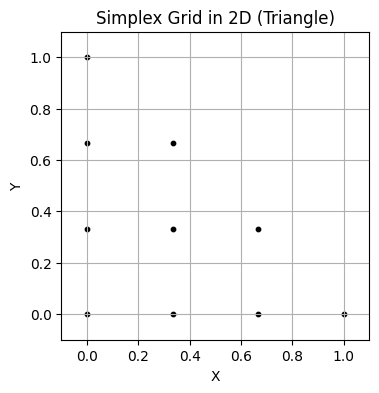

In [ ]:
# ----------------------------------------------
# Generate simplex grid --> triangle (3 templates)
# ---------------------------------------------- 
N = 3
pts = simplex_grid(N) 
print('Number of points in simplex grid with N={}: {}'.format(N, pts.shape[0]))

plot_point_cloud(pts[:, :2], title='Simplex Grid in 2D (Triangle)')
img1 = plt.gcf()



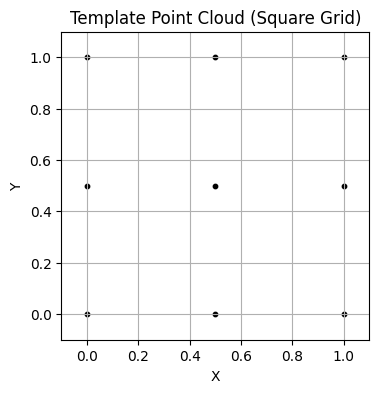

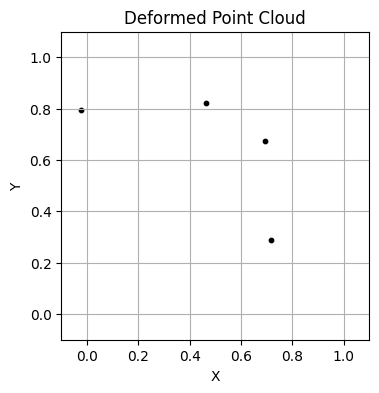

In [ ]:
# ----------------------------------------------
# Example: Generate a template cloud point in 2D that is a uniform grid in a square
# ----------------------------------------------
n_pts_per_side = 3
x = np.linspace(0, 1, n_pts_per_side)
y = np.linspace(0, 1, n_pts_per_side)
X, Y = np.meshgrid(x, y)
template_pts = np.vstack([X.ravel(), Y.ravel()]).T  # shape (n_pts_per_side**2, 2)          

plot_point_cloud(template_pts, title='Template Point Cloud (Square Grid)')
 

# -----------------------------------------------
# Example: Generate a random deformation of the template cloud
# -----------------------------------------------
deformed_pts, disp, ctrl_pts, ctrl_disp, seed = random_rbf_deformation(
    template_pts,
    num_ctrl=15,
    sigma=0.2,
    max_disp=1,
)

plot_point_cloud(deformed_pts, title='Deformed Point Cloud')


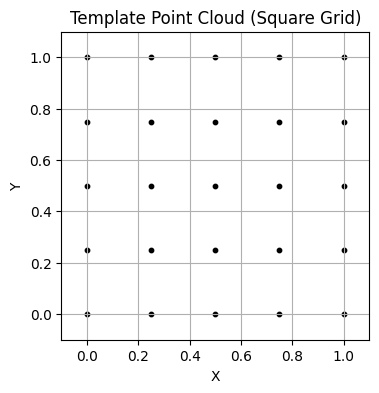

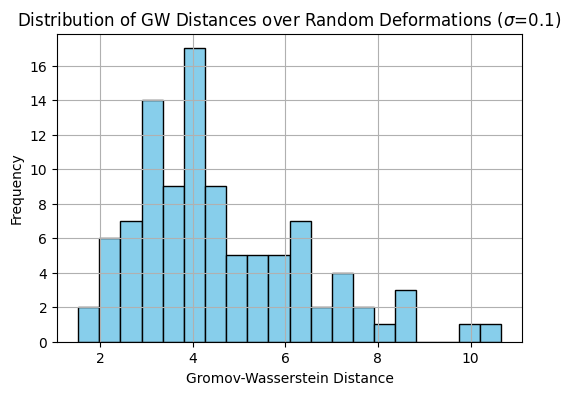

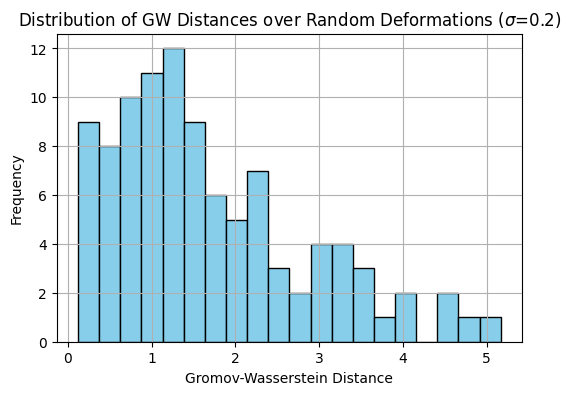

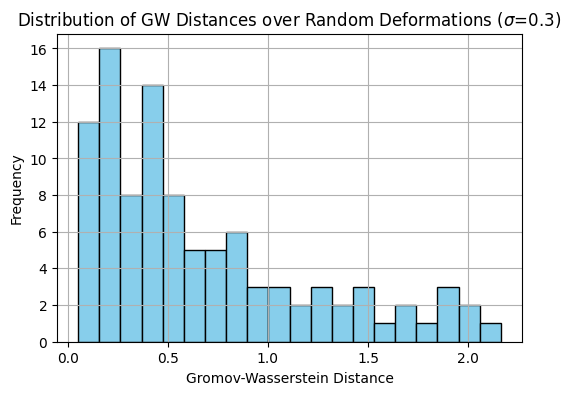

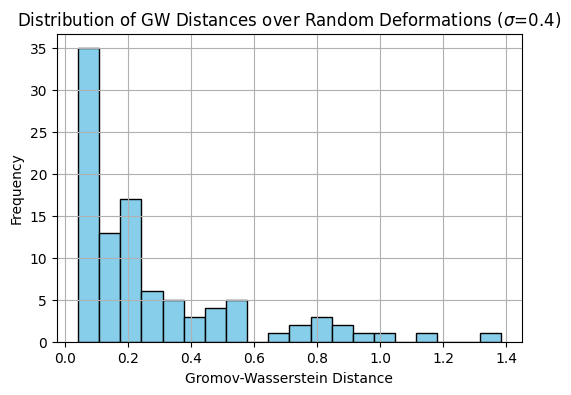

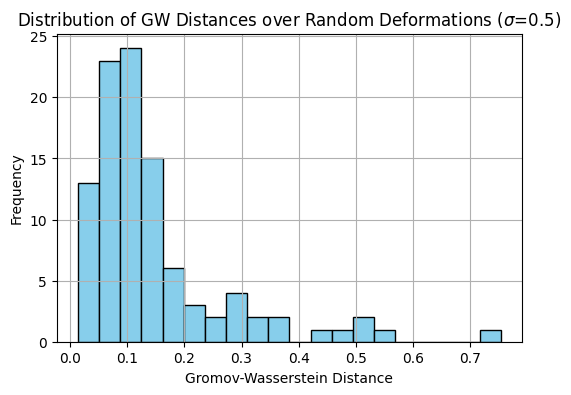

In [75]:
# ----------------------------------------------
# Explore distribution of GW distances over multiple runs to test how the deformation varies the GW distance
# ----------------------------------------------

# Generate a template cloud point in 2D that is a uniform grid in a square
n_pts_per_side = 5
x = np.linspace(0, 1, n_pts_per_side)
y = np.linspace(0, 1, n_pts_per_side)
X, Y = np.meshgrid(x, y)
template_pts = np.vstack([X.ravel(), Y.ravel()]).T  # shape (n_pts_per_side**2, 2)          

plot_point_cloud(template_pts, title='Template Point Cloud (Square Grid)')


# Set deformation parameters
num_control = 10
max_disp = 3.0

for sigma in np.linspace(0.10, 0.50, 5):
    gw_dist_list = np.zeros(100)
    template_dist_matrix = compute_distance_matrix(template_pts)
    for i in range(len(gw_dist_list)):

        deformed_pts, disp, ctrl_pts, ctrl_disp, seed = random_rbf_deformation(
        template_pts,
        num_ctrl=num_control,
        sigma=sigma,
        max_disp=max_disp,
        )
        gw_dist_list[i] = ot.gromov.gromov_wasserstein2(
            compute_distance_matrix(deformed_pts),
            template_dist_matrix,
            ot.unif(deformed_pts.shape[0]),
            ot.unif(template_pts.shape[0]),
            'square_loss'
        )

    plt.figure(figsize=(6,4))
    plt.hist(gw_dist_list, bins=20, color='skyblue', edgecolor='k')
    plt.xlabel('Gromov-Wasserstein Distance')
    plt.ylabel('Frequency')
    plt.title(rf'Distribution of GW Distances over Random Deformations ($\sigma$={sigma:.1f})')
    plt.grid()
    plt.show()


In [116]:
# ----------------------------------------------
# Search for three deformation parameters that yield GW distances to the uniform template larger than a threshold
# ----------------------------------------------        

template_dist_matrix = compute_distance_matrix(template_pts)
threshold = 5
parameter_records = []
gw_dist_list = []
for i in range(100):
    #print(f'Iteration {i+1}/100')
    sigma = np.random.uniform(0.1, 0.5)
    num_control = np.random.randint(5, 20)
    max_disp = np.random.uniform(0.5, 10)

    deformed_pts, disp, ctrl_pts, ctrl_disp, seed = random_rbf_deformation(
        template_pts,
        num_ctrl=num_control,
        sigma=sigma,
        max_disp=max_disp,
    )
    gw_dist = ot.gromov.gromov_wasserstein2(
        compute_distance_matrix(deformed_pts),
        template_dist_matrix,
        ot.unif(deformed_pts.shape[0]),
        ot.unif(template_pts.shape[0]),
        'square_loss'
    )

    if gw_dist > threshold:
        parameter_records.append((sigma, num_control, max_disp, gw_dist, seed))
        gw_dist_list.append(gw_dist)
        print(f'Found deformation with GW distance {gw_dist:.4f} > {threshold}')
        print(f'Parameters: sigma={sigma:.4f}, num_control={num_control}, max_disp={max_disp:.4f}')
        # plot_point_cloud(deformed_pts, title=f'Deformed Point Cloud (GW Dist={gw_dist:.4f})')    

# ----------------------------------------------
# Check that parameters_recorded are more than three templates and can be used to regenerate  the corresponding deformed point clouds and distance matrices
# ----------------------------------------------

assert len(parameter_records) >= 3, "Not enough parameter records found."

gw_dist_list_recovered = []
for idx, (sigma, num_control, max_disp, gw_dist, seed) in enumerate(parameter_records):
    deformed_pts, disp, ctrl_pts, ctrl_disp, seed = random_rbf_deformation(
            template_pts,
            num_ctrl=num_control,
            sigma=sigma,
            max_disp=max_disp,
            seed=seed,
        )
    dist_matrix = compute_distance_matrix(deformed_pts)
    gw_dist_recovered = ot.gromov.gromov_wasserstein2(
        dist_matrix,
        template_dist_matrix,
        ot.unif(deformed_pts.shape[0]),
        ot.unif(template_pts.shape[0]),
        'square_loss'
    )
    gw_dist_list_recovered.append(gw_dist_recovered)

print('Original GW distances:', gw_dist_list)   
print('Recovered GW distances:', gw_dist_list_recovered)

Found deformation with GW distance 8.2206 > 5
Parameters: sigma=0.2461, num_control=10, max_disp=9.9464
Found deformation with GW distance 12.3192 > 5
Parameters: sigma=0.1980, num_control=14, max_disp=7.7783
Found deformation with GW distance 11.3680 > 5
Parameters: sigma=0.2707, num_control=5, max_disp=6.5965
Found deformation with GW distance 7.5524 > 5
Parameters: sigma=0.1121, num_control=16, max_disp=3.5376
Found deformation with GW distance 81.0161 > 5
Parameters: sigma=0.1132, num_control=9, max_disp=9.5299
Found deformation with GW distance 14.6151 > 5
Parameters: sigma=0.2203, num_control=12, max_disp=9.5208
Found deformation with GW distance 7.6380 > 5
Parameters: sigma=0.3360, num_control=11, max_disp=6.5232
Found deformation with GW distance 7.1661 > 5
Parameters: sigma=0.1650, num_control=5, max_disp=4.5644
Found deformation with GW distance 9.4196 > 5
Parameters: sigma=0.2882, num_control=6, max_disp=6.6858
Found deformation with GW distance 6.9267 > 5
Parameters: sigma=

In [117]:
# -----------------------------------------------
# Save generated point clouds and distance matrices to disk
# -----------------------------------------------
base_dir = Path('./20-Exp-generated_data') 
output_dir = Path(create_next_run_folder(base_dir, prefix="run_"))

if True: # Change to false if you don't want to overwrite existing data
    # Eliminates previous data directory and creates a new one
    # if os.path.exists(output_dir):
    #     shutil.rmtree(output_dir)      
    # os.makedirs(output_dir)

    # Save template point cloud and distance matrix
    template_dist_matrix = compute_distance_matrix(template_pts)
    np.savez(output_dir / 'template_point_cloud.npz',
                            points=template_pts,
                            distance_matrix=template_dist_matrix)
    # Save deformed point clouds and distance matrices for each parameter set found
    for idx, (sigma, num_control, max_disp, gw_dist, seed) in enumerate(parameter_records):
        deformed_pts, disp, ctrl_pts, ctrl_disp, seed = random_rbf_deformation(
            template_pts,
            num_ctrl=num_control,
            sigma=sigma,
            max_disp=max_disp,
            seed=seed,
        )
        dist_matrix = compute_distance_matrix(deformed_pts)
        np.savez(
            output_dir / f'deformed_point_cloud_{idx+1}.npz',
            points=deformed_pts,
            distance_matrix=dist_matrix,
            sigma=sigma,
            num_control=num_control,
            max_disp=max_disp,
            seed=seed,
            gw_distance=gw_dist
        )
    print(f'Saved {len(parameter_records)} deformed point clouds to {output_dir}')

Saved 27 deformed point clouds to 20-Exp-generated_data/run_08


In [118]:
# ----------------------------------------------
# Load and compute pairwise GW distance matrix between all generated point clouds
# ----------------------------------------------
base_dir = Path('./20-Exp-generated_data') 
output_dir = Path(find_last_run_folder(base_dir, prefix="run_"))

num_clouds = len(os.listdir(output_dir))
gw_distance_matrix = np.zeros((num_clouds, num_clouds))     

# Load template distance matrix
template_data = np.load(output_dir / 'template_point_cloud.npz')     
template_dist_matrix = template_data['distance_matrix']
gw_distance_matrix[0, 0] = 0.0  # GW distance of template to itself is zero
# Compute GW distances between template and deformed clouds
for idx in range(1, num_clouds):
    deformed_data = np.load(output_dir / f'deformed_point_cloud_{idx}.npz')
    deformed_dist_matrix = deformed_data['distance_matrix']
    gw_dist = ot.gromov.gromov_wasserstein2(
        deformed_dist_matrix,
        template_dist_matrix,
        ot.unif(deformed_dist_matrix.shape[0]),
        ot.unif(template_dist_matrix.shape[0]),
        'square_loss'
    )
    gw_distance_matrix[0, idx] = gw_dist
    gw_distance_matrix[idx, 0] = gw_dist    
# Compute GW distances between deformed clouds
for i in range(1, num_clouds):
    for j in range(i + 1, num_clouds):
        data_i = np.load(output_dir / f'deformed_point_cloud_{i}.npz')
        data_j = np.load(output_dir / f'deformed_point_cloud_{j}.npz')
        dist_matrix_i = data_i['distance_matrix']
        dist_matrix_j = data_j['distance_matrix']
        gw_dist = ot.gromov.gromov_wasserstein2(
            dist_matrix_i,
            dist_matrix_j,
            ot.unif(dist_matrix_i.shape[0]),
            ot.unif(dist_matrix_j.shape[0]),
            'square_loss'
        )
        gw_distance_matrix[i, j] = gw_dist
        gw_distance_matrix[j, i] = gw_dist   

# Print GW distance matrix
np.set_printoptions(linewidth=np.inf)
print('Pairwise GW Distance Matrix:')
print(gw_distance_matrix[::,::])      
           


Pairwise GW Distance Matrix:
[[ 0.          8.22055296 12.31922667 11.36804816  7.55235244 81.01614277 14.61507811  7.63804357  7.16607972  9.41962144  6.92672535 19.54433851  6.81301356  7.8883479   6.44623538 13.31671507 11.63012955  6.90304887 35.6530726   8.91280972 27.29150433 13.46640642  8.94161009 18.0535917  30.4846139  23.9260401  50.61904769 11.52174795]
 [ 8.22055296  0.          2.48646968  2.22802528  1.29370268 42.39197859  2.23715862  1.038619    1.12707839  1.97857572  1.01257409  4.67221676  2.08852274  1.75371509  1.36115357  2.42312092  1.45783007  0.7897905  11.58854686  1.18460763  9.95168887  1.84310402  1.22237109  4.06285903  8.72337653  5.35499768 20.87597296  1.61609908]
 [12.31922667  2.48646968  0.          0.88835481  1.76945305 33.41299719  3.05370216  5.12909591  4.52986592  4.79974793  1.88265779  7.10588018  4.24538501  1.38168542  3.8711388   2.98196089  2.32456728  1.58515313  8.56831688  1.77446013  3.93466772  1.83648491  1.67765662  2.30580909  6.

In [115]:
# ----------------------------------------------
# Load and generate Gromov-Wasserstein barycenters from the first three deformed point clouds and weights in the simplex
# ----------------------------------------------
if True:  # Change to True to recompute barycenters and distances to target
    base_dir = Path('./20-Exp-generated_data')
    output_dir = Path(find_last_run_folder(base_dir, prefix="run_"))
    
    # Load template distance matrix to use as target
    template_data = np.load(output_dir / 'template_point_cloud.npz')     
    template_dist_matrix = template_data['distance_matrix']
    target_dist_matrix = template_dist_matrix

    # Load first three deformed point clouds   
    assert len(os.listdir(output_dir)) >= 4, "Need at least 3 deformed point clouds saved."     
    deformed_dist_matrices = []
    for idx in range(1, 4):
        deformed_data = np.load(output_dir / f'deformed_point_cloud_{idx}.npz')
        deformed_pts = deformed_data['points']
        deformed_dist_matrix = deformed_data['distance_matrix']
        deformed_dist_matrices.append(deformed_dist_matrix)



    import signal 

    class TimeoutException(Exception):
        pass
    def timeout_handler(signum, frame):
        raise TimeoutException
    signal.signal(signal.SIGALRM, timeout_handler)

    max_time = 2 # seconds


    # Iterate over weights in the simplex and compute GW barycenters and their GW distances to the target
    simplex_grid_points = simplex_grid(10)
    simplex_gromov_wasserstein_distances_to_target = []
    for weight_idx, weight in enumerate(tqdm(simplex_grid_points)):
        weights = weight / np.sum(weight)  # Normalize to sum to 1
        try:
            signal.alarm(max_time)  # Set the timeout alarm
            barycenter_dist_matrix = ot.gromov.gromov_barycenters(
                deformed_pts.shape[0], 
                Cs = deformed_dist_matrices, 
                lambdas=weight, 
                loss_fun='square_loss'
            )
            gw_dist_to_target = ot.gromov.gromov_wasserstein2(
            barycenter_dist_matrix,
            target_dist_matrix,
            ot.unif(barycenter_dist_matrix.shape[0]),
            ot.unif(target_dist_matrix.shape[0]),
            'square_loss'
            )
            signal.alarm(0)  # Disable the alarm if completed in time
            simplex_gromov_wasserstein_distances_to_target.append(gw_dist_to_target)
        except TimeoutException:
            simplex_gromov_wasserstein_distances_to_target.append(np.nan)

    np.savez(output_dir / 'Bary_distances_to_target.npz',
                                simplex_grid_points=simplex_grid_points,
                                deformed_dist_matrices=deformed_dist_matrices,
                                target_dist_matrix=target_dist_matrix,
                                simplex_gromov_wasserstein_distances_to_target=simplex_gromov_wasserstein_distances_to_target
                                )    



100%|██████████| 66/66 [00:10<00:00,  6.20it/s]


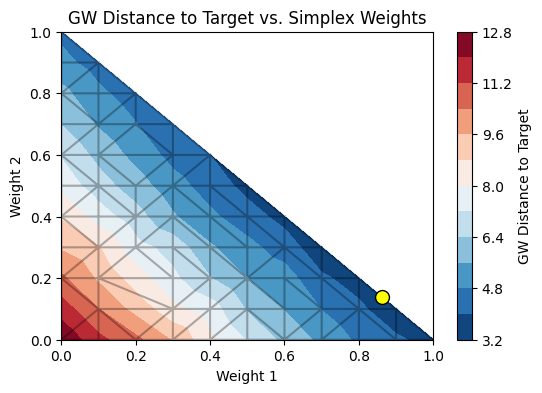

In [80]:
import matplotlib.tri as tri

base_dir = Path('./20-Exp-generated_data')
output_dir = Path(find_last_run_folder(base_dir, prefix="run_"))

# Load template distance matrix to use as target
template_data = np.load(output_dir / 'template_point_cloud.npz')     
template_dist_matrix = template_data['distance_matrix']
target_dist_matrix = template_dist_matrix

# Load first three deformed point clouds   
assert len(os.listdir(output_dir)) >= 4, "Need at least 3 deformed point clouds saved."     
deformed_dist_matrices = []
deformed_measures = []
for idx in range(1, 4):
    deformed_data = np.load(output_dir / f'deformed_point_cloud_{idx}.npz')
    deformed_pts = deformed_data['points']
    deformed_dist_matrix = deformed_data['distance_matrix']
    deformed_dist_matrices.append(deformed_dist_matrix)
    deformed_measures.append(ot.unif(barycenter_dist_matrix.shape[0]))   

# Load previously computed barycenter distances to target
bary_dist_data = np.load(output_dir / 'Bary_distances_to_target.npz')
simplex_grid_points = bary_dist_data['simplex_grid_points']
simplex_gromov_wasserstein_distances_to_target = bary_dist_data['simplex_gromov_wasserstein_distances_to_target']

# Compute analysis of target 
_, lambdas = utils.get_lambdas_constraints(deformed_dist_matrices,deformed_measures,target_dist_matrix, ot.unif(target_dist_matrix.shape[0]))

# Clean up NaN values for plotting
z = simplex_gromov_wasserstein_distances_to_target
mask = np.isnan(z)
z_masked = z[~mask]
x_grid_points = simplex_grid_points[~mask,0]
y_grid_points = simplex_grid_points[~mask,1]

# Plot GW distances to target vs. simplex weights
plt.figure(figsize=(6,4))
plt.tricontourf(x_grid_points, y_grid_points, z_masked, levels=14, cmap="RdBu_r")
plt.colorbar(label='GW Distance to Target')
plt.xlabel('Weight 1')
plt.ylabel('Weight 2')
plt.title('GW Distance to Target vs. Simplex Weights')
# Add triangulation grid
triang = tri.Triangulation(x_grid_points, y_grid_points)
plt.triplot(triang, color='k', alpha=0.3)
plt.scatter(lambdas[0], lambdas[1], color='yellow', s=100, edgecolor='k', label='Computed Weights')
plt.show()


# # Scatter plot of GW distances to target vs. simplex weights
# plt.figure(figsize=(6,4))
# plt.scatter(x_grid_points, y_grid_points, c=z_masked, cmap='RdBu_r')
# plt.colorbar(label='GW Distance to Target')
# plt.xlabel('Weight 1')
# plt.ylabel('Weight 2')
# plt.title('GW Distance to Target vs. Simplex Weights')
# plt.scatter(lambdas[0], lambdas[1], color='yellow', s=100, edgecolor='k', label='Computed Weights')
# plt.show()
